# Lead-field matrix 

The objective of this program is to compute the lead-field matrix for the adult template dataset, "fsaverage", within the framework of standard EEG configuration and the Automated Anatomical Labeling (AAL) atlas serving as the source space. The fsaverage dataset can be substituted with user-specific data if required.

### Import modules 

In [1]:
import os
import numpy as np

import nibabel as nib
import mne
from mne.datasets import eegbci
from mne.datasets import fetch_fsaverage

import logging
from xml.etree import ElementTree
from neurolib.utils.atlases import AutomatedAnatomicalParcellation2

### Download and load the data
Download the template MRI "fsaverage", user-specific data can replace the dataset.

In [2]:
# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

# The files live in:
subject = "fsaverage"
trans = os.path.join(subjects_dir, "fsaverage", "bem", "fsaverage-trans.fif") # MNE has a built-in fsaverage transformation

0 files missing from root.txt in /home/ben/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/ben/mne_data/MNE-fsaverage-data/fsaverage


### Set conductivity of tissues and compute BEM
Setting conductivity based on the type of the tissues, calculate the BEM of the data, further visualize BEM surfaces. There is a a pre build-up BEM for the data "fsaverage".

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
outer skin  CM is  -0.21 -19.38  -0.23 mm
outer skull CM is  -0.19 -19.34  -0.49 mm
inner skull CM is  -0.53 -21.10   6.21 mm
Checking that surface outer skull is inside surface outer skin  ...
Checking that surface inner skull is inside surface outer skull ...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    1.6 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately    5.4 mm
Surfaces passed the basic topology checks.
Complete.

Three-layer model surfaces loaded.
Computing the linear collocation solution...
    Matrix coefficients...
     

/home/ben/anaconda3/envs/mne_py39/lib/python3.9/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


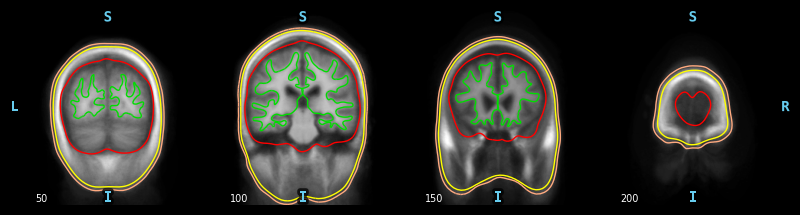

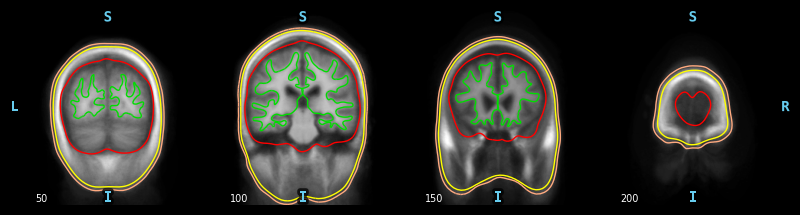

In [3]:
# Manually build up BEM
conductivity = (0.3, 0.006, 0.3)  # for three layers
#conductivity = (0.3,)  # for single layer
model = mne.make_bem_model(subject=subject, ico=4, conductivity=conductivity, subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

# Default BEM for "fsavergae"
#bem = op.join(fs_dir, "bem", "fsaverage-5120-5120-5120-bem-sol.fif")

# Visualization of the BEM
plot_bem_kwargs = dict(
    subject=subject,
    subjects_dir=subjects_dir,
    brain_surfaces="white",
    orientation="coronal",
    slices=[50, 100, 150, 200],
)

mne.viz.plot_bem(**plot_bem_kwargs)

### Generate surface source space
The method to achieve AAL atlas source space is to calculate the average dipole value of all dipoles in each annotation of the atlas, so at first place, the surface source space needed to be generated. The data "fsaverage" has a pre build-up surface source space, nevertheless, the source space can also be calculated.

Using surface: /home/ben/mne_data/MNE-fsaverage-data/fsaverage/bem/inner_skull.surf
Using surface: /home/ben/mne_data/MNE-fsaverage-data/fsaverage/bem/outer_skull.surf
Using surface: /home/ben/mne_data/MNE-fsaverage-data/fsaverage/bem/outer_skin.surf
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read


/home/ben/anaconda3/envs/mne_py39/lib/python3.9/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


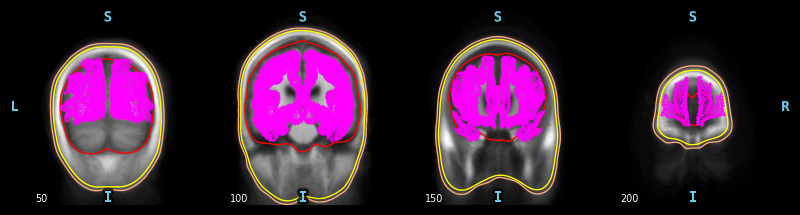

In [4]:
src = os.path.join(fs_dir, "bem", "fsaverage-ico-5-src.fif")
#src = mne.setup_source_space(subject, spacing="ico4", add_dist="patch", subjects_dir=subjects_dir)
#src = mne.setup_source_space(subject, spacing="oct4", add_dist="patch", subjects_dir=subjects_dir)
#src = mne.setup_source_space(subject, spacing="all", add_dist="patch", subjects_dir=subjects_dir)

mne.viz.plot_bem(src=src, **plot_bem_kwargs)

### Load and coregistrate standard EEG configuration
The standard 1020 EEG electrode locations are already calculated in fsaverage's space (MNI space)

In [5]:
# Load the data
(raw_fname,) = eegbci.load_data(subject=1, runs=[6])
raw = mne.io.read_raw_edf(raw_fname, preload=True)

# Clean channel names to be able to use a standard 1020 montage
new_names = dict(
    (ch_name, ch_name.rstrip(".").upper().replace("Z", "z").replace("FP", "Fp"))
    for ch_name in raw.ch_names
)
raw.rename_channels(new_names)

# Read and set the EEG electrode locations, which are already in fsaverage's space (MNI space) for standard_1020:
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)
raw.set_eeg_reference(projection=True)  # needed for inverse modeling

# Check that the locations of EEG electrodes is correct with respect to MRI
def plot_EEG_montage(demo):
    if demo == True:
        mne.viz.plot_alignment(
            raw.info,
            src=src,
            eeg=["original", "projected"],
            trans=trans,
            show_axes=True,
            mri_fiducials=True,
            dig="fiducials",
    )

plot_EEG_montage(False)

Extracting EDF parameters from /home/ben/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


### Calculate the general forward solution
The overall forward solution between surface source model and standard EEG montage is computed

In [6]:
fwd = mne.make_forward_solution(raw.info, trans=trans, src=src, bem=bem, eeg=True, mindist=5.0, n_jobs=None)
leadfield = fwd["sol"]["data"]
print(fwd)

Source space          : /home/ben/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /home/ben/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /home/ben/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  64 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

### Downsample the forward solution to achieve lead-field matrix
With the forward solution that being calculated above, compute the average dipole value of the dipoles in each AAL atlas to acquire the lead-field matrix.

In [7]:
def filter_for_regions(label_strings, regions):
    """Create a list of bools if the label_strings are in the regions list. This function can be used if one is only
    interested in a subset of regions defined by an atlas.
    :param label_strings: List of labels that dipoles got assigned to.
    :type label_strings: list[str]
    :param regions: List of strings that are the acronyms for the regions of interest.
    :type regions: list[str]
    :return: List of bools that, . Sorted according to the order of "label_strings".
    :rtype: list[bool]
    """
    # Remark: then outside this function the label codes and label-strings can be set to nan or 0 for dipoles that are
    #  not of interest such that downsampling works smoothly.
    in_regions = [None] * len(label_strings)
    for idx_label, label in enumerate(label_strings):
        if label in regions:
            in_regions[idx_label] = True
        else:
            in_regions[idx_label] = False
    return in_regions


def create_label_lut(path):
    """Create a lookup table that contains "anatomical acronyms" corresponding to the encodings of the regions
    specified by the used anatomical atlas. Adds an empty label for code "0" if not specified otherwise by atlas.
    :param path:    ToDo: proper variable naming depending of the final implementation.
    :type path:     str
    :return :       Dictionary with keys being the integer codes of regions and the values being
    :rtype:         dict
    """

    # Look up the codes ("index") and the names of the regions defined by the atlas.
    tree = ElementTree.parse(path)
    root = tree.getroot()
    label_lut = {}
    for region in root.find("data").findall("label"):
        label_lut[region.find("index").text] = region.find("name").text

    if "0 " not in label_lut.keys():
        label_lut["0"] = ""
    return label_lut

def get_backprojection(point_expanded, affine, affine_inverse):
    """Transform MNI-mm-point into 'voxel-coordinate'.
    :param point_expanded : First elements being the 3d point in MNI-coordinate space (mm),
                            last element being a 1 for the offset in transformations.
    :type point_expanded:   np.ndarray of shape 4x1
    :param affine:          Projects voxel-numbers to MNI coordinate space (mm).
    :type affine:           np.ndarray of shape 4x4
    :param affine_inverse:  Back projection from MNI space.
    :type affine_inverse:   np.ndarray of shape 4x4
    :return :               The point projected back into "voxel-number-space", last element 1.
    :rtype:                 np.ndarray of shape 4x1
    """
    back_proj = affine_inverse @ point_expanded  # project the point from mni to voxel

    # Round to voxel resolution, multiplication with elements inverse is equivalent to division with elements of the
    # affine here.
    back_proj_rounded = np.round(np.diag(affine_inverse) * back_proj, 0) * np.diag(
        affine
    )

    return back_proj_rounded

def get_labels_of_points(points, nii_file, xml_file, atlas="aal2_cortical", cortex_parts = "full_cortex"):
    """Gives labels of regions the points fall into.
    :param points : Nx3 ndarray of points defined in MNI space (mm).
    :type points:   np.ndarray
    :param atlas :  Specification of the anatomical atlas, defaults to "aal2". Remark: Currently only AAL2 is supported.
    :type atlas:    string
    :return :       Tuple. First element is a list of bools, indicating for each point if a valid assignment within
                    the space defined by the atlas was found. Second element array of the assigned label-codes.
                    Third, list of strings of the "anatomical acronyms".
    :rtype:         tuple[list[bool], np.ndarray, list[str]]
    """
    n_points = points.shape[0]
    label_codes = np.zeros(
        n_points
    )  # Remark: or expand points-array by one dimension and fill label-codes in there?
    label_strings = [None] * n_points
    points_found = [None] * n_points

    points_expanded = np.ones(
        (n_points, 4)
    )  # Expand by a column with ones only to allow for transformations
    points_expanded[:, 0:3] = points  # with affines.

    if not points.shape[1] == 3:
        raise ValueError

    # Load atlas (integer encoded volume and string-labels).
    #if atlas == "aal2" or atlas == "aal2_cortical":
    #    atlas_path = os.path.join(
    #        os.path.dirname(__file__),
    #        "../../../..",
    #        "neurolib",
    #        "data",
    #        "datasets",
    #        "aal",
    #        "atlas",
    #    )
    #    atlas_img = nib.load(os.path.join(atlas_path, "AAL2.nii"))
    #    atlas_labels_lut = create_label_lut(os.path.join(atlas_path, "AAL2.xml"))
    #else:
    #    raise ValueError("Currently only 'aal2' is supported.")
    atlas_img = nii_file
    atlas_labels_lut = xml_file

    affine = atlas_img.affine  # Transformation from voxel- to mni-space.
    affine_inverse = np.linalg.inv(affine)  # Transformation mni- to "voxel"-space.

    # Get voxel codes
    codes = atlas_img.get_fdata()
    for point_idx, point in enumerate(points_expanded):
        back_proj = get_backprojection(point, affine, affine_inverse)

        try:
            label_codes[point_idx] = codes[
                int(back_proj[0]), int(back_proj[1]), int(back_proj[2])
            ]

        except IndexError:
            label_codes[point_idx] = np.NAN

        if np.isnan(label_codes[point_idx]):
            points_found[point_idx] = False
            label_strings[point_idx] = "invalid"
        else:
            points_found[point_idx] = True
            label_strings[point_idx] = atlas_labels_lut[
                str(int(label_codes[point_idx]))
            ]  # ToDo: clean up type-
            # conversions.
    if sum(points_found) < n_points:
        logging.error(
            f"The atlas does not specify valid labels for all the given points.\n"
            f"Total number of points: (%s) out of which (%s) were validly assigned."
            % (n_points, sum(points_found))
        )

    if atlas == "aal2_cortical":   
        aal_2 = AutomatedAnatomicalParcellation2()
        regions = []
        k = 0

        # Select cortex part
        full_cortex = aal_2.cortex + aal_2.subcortical 
        only_cortex = aal_2.cortex
        subcortical_parts = aal_2.subcortical
        
        if cortex_parts == "full_cortex":
            cortex_parts = full_cortex
        if cortex_parts == "only_cortex":
            cortex_parts = only_cortex
        if cortex_parts == "subcortical_parts":
            cortex_parts = subcortical_parts

        for r in cortex_parts:
            regions.append(aal_2.aal2[r + 1])
            in_regions = filter_for_regions(label_strings, regions)
            k = k+1

        for idx_point in range(len(points_found)):
            if not in_regions[idx_point]:
                label_codes[idx_point] = 0
                label_strings[idx_point] = ""
        
        print("regions number:",k)

    return points_found, label_codes, label_strings

def downsample_leadfield_matrix(leadfield, label_codes):
    """Take a leadfield-matrix (assumes one dipole for each source position, e.g. the usual case for a surface
    source space with orientation of dipoles set as surface normals) and down sample it to an average across all
    dipoles that fall into a region.
    :param leadfield :      Leadfield matrix. Channels x Dipoles.
    :type leadfield:        np.ndarray
    :param label_codes :    1D array of region-labels assigned to the source locations
    :type label_codes:      np.ndarray
    :return :               First, array that contains the label-codes of any region that at least one dipole was
                            assigned to.
                            Second, array that contains Channels x Regions leadfield matrix. The order of rows
                            (channels) is unchanged compared to the input "leadfield", the columns are sorted
                            according to the "unique_labels" array.
    :rtype:                 tuple[np.ndarray, np.ndarray]
    """
    leadfield_orig_shape = leadfield.shape
    n_channels = leadfield_orig_shape[0]

    if leadfield_orig_shape[1] != label_codes.size:
        raise ValueError(
            "The lead field matrix does not have the expected number of columns. \n"
            "Number of columns differs from labels (equal number dipoles)."
        )
    
    unique_labels = np.unique(label_codes)
    unique_labels = np.delete(
        unique_labels, np.where(np.isnan(unique_labels))[0]
    )  # Delete NAN if present.
    # NAN would indicate point that
    # doesn't fall into space
    # covered by atlas.
    unique_labels = np.delete(
        unique_labels, np.where(unique_labels == 0)[0]
    )  # Delete 0 if present. "0" in AAL2
    # is non-brain-tissue, eg. CSF.

    downsampled_leadfield = np.zeros((n_channels, unique_labels.size))

    for label_idx, label in enumerate(unique_labels):  # iterate through regions
        indices_label = np.where(label_codes == label)[0]

        downsampled_leadfield[:, label_idx] = np.mean(
            leadfield[:, indices_label], axis=1
        )

    return unique_labels, downsampled_leadfield


In [8]:
fwd_fixed = mne.convert_forward_solution(
    fwd, surf_ori=True, force_fixed=True, use_cps=True
)

leadfield_fixed = fwd_fixed["sol"]["data"]
#print(leadfield_fixed.shape)

lh = fwd_fixed['src'][0]
dip_pos_lh = np.vstack(lh['rr'][lh['vertno']])
rh = fwd_fixed['src'][1]
dip_pos_rh = np.vstack(rh['rr'][rh['vertno']])

dip_pos = np.vstack((dip_pos_lh, dip_pos_rh))

trans_info = mne.read_trans(trans)

dip_pos_mni = mne.head_to_mni(dip_pos, subject=subject, mri_head_t=trans_info)

nii_file = nib.load("AAL2_atlas_data/AAL2.nii")
xml_file = create_label_lut("AAL2_atlas_data/AAL2.xml")

points_found, label_codes, label_strings = get_labels_of_points(dip_pos_mni, nii_file, xml_file, atlas= "aal2_cortical", cortex_parts = "full_cortex")

unique_labels, leadfield_downsampled = downsample_leadfield_matrix(leadfield_fixed, label_codes)

print(np.array(points_found).shape)
print("Leadfield size : %d sensors x %d dipoles" % leadfield_downsampled.shape)
print(leadfield_downsampled)



    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]


regions number: 120
(20484,)
Leadfield size : 64 sensors x 94 dipoles
[[ 46.0499115   -8.10420036  51.77446747 ... -19.40752983   5.79743576
  -12.36075878]
 [ 63.07761765  -3.93809652  81.55727386 ... -22.51317406  -9.20882988
  -24.8643074 ]
 [ 45.61634445   4.58903265  83.16187286 ... -24.48542023 -23.28250694
  -35.49036789]
 ...
 [-17.10632133 -12.98373508 -18.83823586 ...   5.47431898  40.55622482
   28.58356476]
 [-17.82714272 -12.14234829 -22.45002937 ...  17.09500885  29.23259163
   25.36248589]
 [-18.07602882 -14.23802567 -20.28145409 ...  16.43236351  59.21129227
   64.51577759]]


### Investigation of the missing regions of AAL atlas
Can be implemented if the downsample lead-field matrix does possess not an anticipated size.

In [9]:
aal_2 = AutomatedAnatomicalParcellation2()
full_cortex = aal_2.cortex + aal_2.subcortical
total_region_quantity = np.array(full_cortex).shape[0]

print("total region number:", total_region_quantity)

xml_file = create_label_lut("AAL2_atlas_data/AAL2.xml")
label_numbers = np.array(list(map(int, xml_file.keys())))[:-1]  # Convert the keys to integers
missed_region_labels = np.setdiff1d(label_numbers, unique_labels)
print("missed region labels:", missed_region_labels)

missed_region_labels_str = missed_region_labels.astype(str)
#missed_region_labels_str = np.core.defchararray.add(missed_region_labels.astype(str), '')
missed_region_values = list(xml_file[label] for label in missed_region_labels_str if label in xml_file)
print("missed region names:", missed_region_values)

subset = set(missed_region_labels)
missed_region_index = np.array([i+1 for i, e in enumerate(label_numbers) if e in subset])
print("missed region index:", missed_region_index)


total region number: 120
missed region labels: [7021 7022 9001 9002 9011 9012 9021 9022 9031 9041 9051 9052 9061 9062
 9071 9072 9081 9082 9100 9110 9120 9130 9140 9150 9160 9170]
missed region names: ['Pallidum_L', 'Pallidum_R', 'Cerebelum_Crus1_L', 'Cerebelum_Crus1_R', 'Cerebelum_Crus2_L', 'Cerebelum_Crus2_R', 'Cerebelum_3_L', 'Cerebelum_3_R', 'Cerebelum_4_5_L', 'Cerebelum_6_L', 'Cerebelum_7b_L', 'Cerebelum_7b_R', 'Cerebelum_8_L', 'Cerebelum_8_R', 'Cerebelum_9_L', 'Cerebelum_9_R', 'Cerebelum_10_L', 'Cerebelum_10_R', 'Vermis_1_2', 'Vermis_3', 'Vermis_4_5', 'Vermis_6', 'Vermis_7', 'Vermis_8', 'Vermis_9', 'Vermis_10']
missed region index: [ 79  80  95  96  97  98  99 100 101 103 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120]


### Obtain the index of the subthalamic nucleus location in AAL2

In [19]:
xml_file = create_label_lut("AAL2_atlas_data/AAL2.xml")
label_numbers = np.array(list(map(int, xml_file.keys())))[:-1]  # Convert the keys to integers
empty_set = []
all_region_labels = np.setdiff1d(label_numbers, empty_set)
#print("all region labels:", all_region_labels)

all_region_labels_str = all_region_labels.astype(str)
all_region_values = list(xml_file[label] for label in all_region_labels_str if label in xml_file)
#print("all region names:", all_region_values)

all_subset = set(all_region_labels)
all_region_index = np.array([i+1 for i, e in enumerate(label_numbers) if e in all_subset])
#print("all region index:", all_region_index)

thalamus_l_index = all_region_values.index('Thalamus_L')
thalamus_r_index = all_region_values.index('Thalamus_R')

print("Index for Thalamus_L:", thalamus_l_index)
print("Index for Thalamus_R:", thalamus_r_index)

Index for Thalamus_L: 80
Index for Thalamus_R: 81


First Attempt

In [17]:
"""
n_timepoints = 1000
n_dipoles = leadfield_downsampled.shape[1]

# Randomly generate source activity (you can also design specific patterns if needed)
simulated_source_activity = np.random.randn(n_dipoles, n_timepoints)

simulated_eeg_data = np.dot(leadfield_downsampled, simulated_source_activity)

import matplotlib.pyplot as plt

def plot_simulated_eeg(data, times):
    plt.figure(figsize=(10, 8))
    for i in range(data.shape[0]):
        plt.plot(times, data[i, :] + i * 10, label=f"Sensor {i+1}")  # Offset for clarity
    plt.xlabel('Time (ms)')
    plt.ylabel('EEG data (with offset)')
    plt.title('Simulated EEG Data')
    plt.tight_layout()
    plt.show()

times = np.arange(n_timepoints)  # Let's assume time in ms for this example
plot_simulated_eeg(simulated_eeg_data, times) 
"""


'\nn_timepoints = 1000\nn_dipoles = leadfield_downsampled.shape[1]\n\n# Randomly generate source activity (you can also design specific patterns if needed)\nsimulated_source_activity = np.random.randn(n_dipoles, n_timepoints)\n\nsimulated_eeg_data = np.dot(leadfield_downsampled, simulated_source_activity)\n\nimport matplotlib.pyplot as plt\n\ndef plot_simulated_eeg(data, times):\n    plt.figure(figsize=(10, 8))\n    for i in range(data.shape[0]):\n        plt.plot(times, data[i, :] + i * 10, label=f"Sensor {i+1}")  # Offset for clarity\n    plt.xlabel(\'Time (ms)\')\n    plt.ylabel(\'EEG data (with offset)\')\n    plt.title(\'Simulated EEG Data\')\n    plt.tight_layout()\n    plt.show()\n\ntimes = np.arange(n_timepoints)  # Let\'s assume time in ms for this example\nplot_simulated_eeg(simulated_eeg_data, times) \n'

### External stimulation at the thalamus
In this section, a randomly simulated brain activity was generated, through the multiplication of the lead-field matrix the simulated EEG signals are obtained. Then an external additive stimulation at the thalamus was added to the original simulated brain activity, multiplying it with the lead-field matrix to have the simulated EEG signals that corresponded to the externally stimulated thalamus area. Finally, plot the two EEG data, and store them as CSV files for statistical and medical analysis 

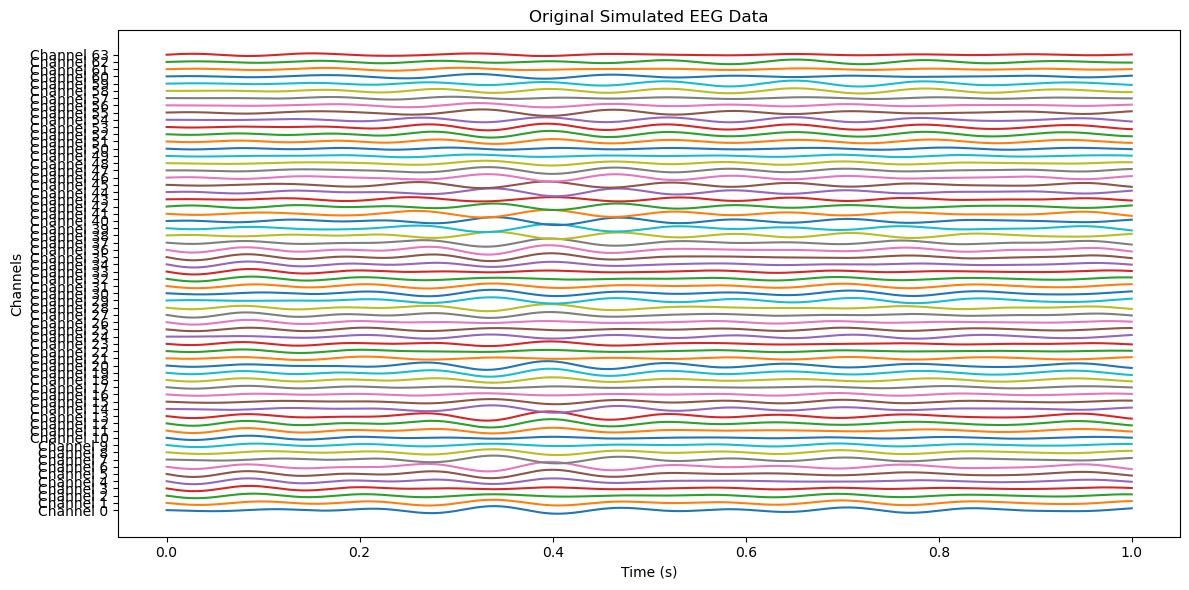

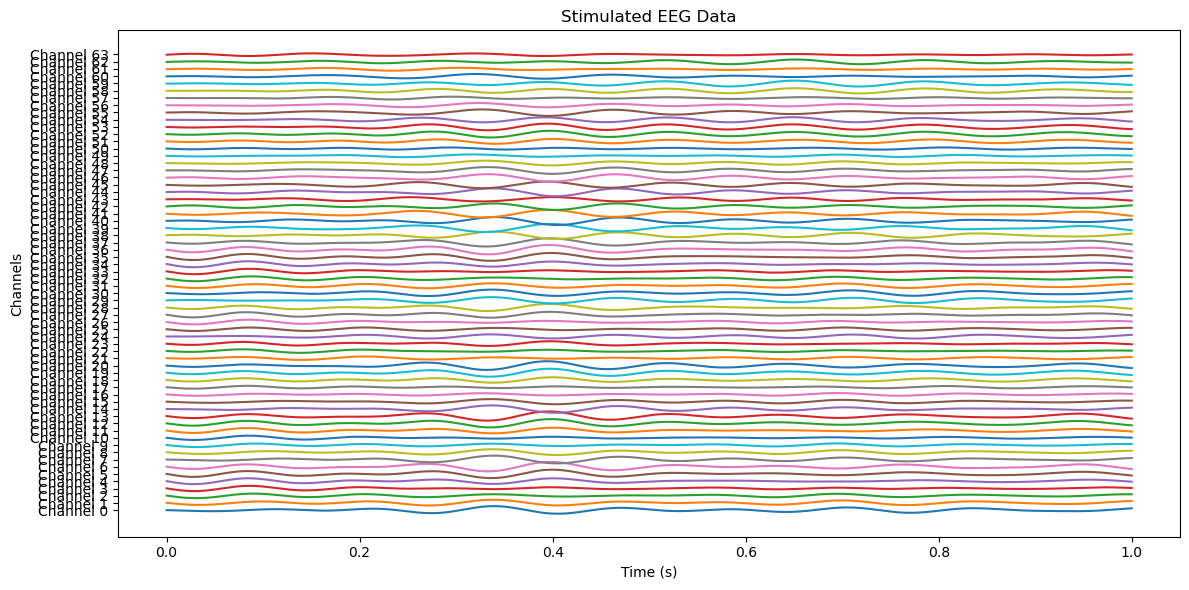

In [21]:
import numpy as np
import matplotlib.pyplot as plt

n_dipoles = leadfield_downsampled.shape[1]  # Number of dipoles
n_timepoints = 1000  # Number of time points in the simulated data
frequencies = np.random.uniform(5, 10, n_dipoles)  # Random frequencies for each dipole
time = np.linspace(0, 1, n_timepoints)  # 1 second of data

# Create source time-series: [n_dipoles x n_timepoints]
simulated_source_data = np.array([np.sin(2 * np.pi * f * time) for f in frequencies])

# Multiply Source Data with Lead Field Matrix
# Simulate EEG data: [n_sensors x n_timepoints]
simulated_eeg_data = np.dot(leadfield_downsampled, simulated_source_data)

# Introduce external stimulation at indices 80 and 81
simulated_source_data_stimulated = np.copy(simulated_source_data)
stimulation_magnitude = np.max(simulated_source_data) * 0.5  # Define an appropriate stimulation magnitude
simulated_source_data_stimulated[thalamus_l_index] += stimulation_magnitude
simulated_source_data_stimulated[thalamus_r_index] += stimulation_magnitude

# Compute the simulated EEG data with the stimulation
simulated_eeg_data_stimulated = np.dot(leadfield_downsampled, simulated_source_data_stimulated)

# Plot the original and stimulated EEG data for comparison

# Define an offset between each channel's plot
offset_per_channel = np.max(np.abs(simulated_eeg_data)) * 1.5

# Define a function to plot EEG data for all channels
def plot_eeg_data(eeg_data, title, offset_per_channel):
    channel_offsets = np.arange(eeg_data.shape[0]) * offset_per_channel
    for i, channel_data in enumerate(eeg_data):
        plt.plot(time, channel_data + channel_offsets[i], label=f'Channel {i}')
    plt.yticks(channel_offsets, [f'Channel {i}' for i in range(eeg_data.shape[0])])
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Channels")
    plt.tight_layout()

# Plot the original EEG data
plt.figure(figsize=(12, 6))
plot_eeg_data(simulated_eeg_data, "Original Simulated EEG Data", offset_per_channel)

# Plot the stimulated EEG data
plt.figure(figsize=(12, 6))
plot_eeg_data(simulated_eeg_data_stimulated, "Stimulated EEG Data", offset_per_channel)

plt.show()

import pandas as pd

# Convert the EEG data to DataFrame
df_original = pd.DataFrame(simulated_eeg_data.T, columns=[f'Channel_{i}' for i in range(simulated_eeg_data.shape[0])])
df_original['Type'] = 'Original'

df_stimulated = pd.DataFrame(simulated_eeg_data_stimulated.T, columns=[f'Channel_{i}' for i in range(simulated_eeg_data_stimulated.shape[0])])
df_stimulated['Type'] = 'Stimulated'

# List to store individual dataframes for each channel
dfs = []

# Loop through each channel and create individual dataframes
for i in range(simulated_eeg_data.shape[0]):
    df_channel = pd.DataFrame({
        f'Channel_{i+1}_Original': simulated_eeg_data[i, :],
        f'Channel_{i+1}_Stimulated': simulated_eeg_data_stimulated[i, :]
    })
    dfs.append(df_channel)

# Concatenate individual dataframes along columns axis
df_pairwise = pd.concat(dfs, axis=1)

# Save to CSV
df_pairwise.to_csv('pairwise_simulated_eeg_data.csv', index=False)

### Generate simulated source data
This is another approach that adds external stimulation at the surface source dipole model without using the lead-field matrix. Not recommened.

In [13]:
from mne.datasets import sample

print(__doc__)

# For this example, we will be using the information of the sample subject. 
# This will download the data if it not already on your machine. We also set the subjects directory so we don’t need to give it to functions.
data_path = sample.data_path()
subjects_dir = data_path / "subjects"
subject = "sample"


# First, we get an info structure from the test subject.
evoked_fname = data_path / "MEG" / subject / "sample_audvis-ave.fif"
info = mne.io.read_info(evoked_fname)
tstep = 1.0 / info["sfreq"]

print("tstep:",tstep)


# To simulate sources, we also need a source space. It can be obtained from the forward solution of the sample subject.
fwd_fname = data_path / "MEG" / subject / "sample_audvis-meg-eeg-oct-6-fwd.fif"
fwd = mne.read_forward_solution(fwd_fname)
src = fwd["src"]


# To select a region to activate, we use the caudal middle frontal to grow a region of interest.
selected_label = mne.read_labels_from_annot(
    subject, regexp="caudalmiddlefrontal-lh", subjects_dir=subjects_dir
)[0]
location = "center"  # Use the center of the region as a seed.
extent = 10.0  # Extent in mm of the region.
label = mne.label.select_sources(
    subject, selected_label, location=location, extent=extent, subjects_dir=subjects_dir
)


# Define the time course of the activity for each source of the region to activate. 
# Here we use a sine wave at 18 Hz with a peak amplitude of 10 nAm.
source_time_series = np.sin(2.0 * np.pi * 18.0 * np.arange(100) * tstep) * 10e-9


# Define when the activity occurs using events. 
# The first column is the sample of the event, the second is not used, and the third is the event id. Here the events occur every 200 samples.
n_events = 50
events = np.zeros((n_events, 3), int)
events[:, 0] = 100 + 200 * np.arange(n_events)  # Events sample.
events[:, 2] = 1  # All events have the sample id.


# Create simulated source activity. Here we use a SourceSimulator whose add_data method is key. 
# It specified where (label), what (source_time_series), and when (events) an event type will occur.
source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)
source_simulator.add_data(label, source_time_series, events)


# Project the source time series to sensor space and add some noise. 
# The source simulator can be given directly to the simulate_raw function.
raw = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)
cov = mne.make_ad_hoc_cov(raw.info)
mne.simulation.add_noise(raw, cov, iir_filter=[0.2, -0.2, 0.04])
#raw.plot()


# Plot evoked data to get another view of the simulated raw data.
events = mne.find_events(raw)
epochs = mne.Epochs(raw, events, 1, tmin=-0.05, tmax=0.2)
evoked = epochs.average()
#evoked.plot()


Automatically created module for IPython interactive environment
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
tstep: 0.0016649601096532323
Reading forward solution from /home/ben/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
  